# Object Detection

This notebook trains a PyTorch object detection algorithm ([Yolov5](https://github.com/ultralytics/yolov5)) using the [limbo-ml](https://limbo-ml.readthedocs.io/en/latest/data.html#Downloads) dataset to determine the presence or absence  of 30B and 48-type containers.

This notebook uses Campaigns 2, 3, and 6 to train the network and the Reference data to test the network. A description of the data is provided in the [Campaigns tab](https://limbo-ml.readthedocs.io/en/latest/data.html#Campaigns).

* Reference the `Download Data` Cell in this notebook for accessing the Limbo Data.

* Note - This notebook offers an alternative to analyzing the data without using the limbo software

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw, ImageFont
import json
import os
import cv2
from pathlib import Path
from tqdm import tqdm
from IPython.display import display
from sklearn.utils import shuffle
import yaml
print("PyTorch Version: ",torch.__version__)

# Imports for helper functions
import subprocess
import shutil
import xml.etree.cElementTree as ET

Populating the interactive namespace from numpy and matplotlib
PyTorch Version:  1.11.0+cu102


# Confirm Pytorch was installed correctly and is using a GPU

We will train using nVidia GPU hardware; if you don’t have any, you can use a cpu, but your training times will be very long:

In [2]:
assert torch.cuda.is_available() == True, "PyTorch was not installed correctly"

# Helper functions

* These could be written to a script and read-in from there but for simplicity let's define them all here

In [3]:
def change_img_extension(img_name):
    '''
    change_img_extension converts a .exr file to png
    returns new name of img as .png
    '''
    if img_name.endswith('.exr'):
        img_name = img_name.split('.')[0] + '.png'
    return img_name


def make_directory(path, dataset_type):
    dir_path = Path(f"{path}{dataset_type}")
    dir_path.mkdir(parents=True, exist_ok=True)
    return dir_path


def convert_to_yolov5(json_files,
                      categories,
                      dataset_type,
                      json_directory,
                      image_directory,
                      labels_directory,
                      category_dict,
                      reference_imgs=False):
    '''
    convert_to_yolov5 ingests the json_files and writes images and txt
    files to separate directories
    json_files is a list of json files
    categories - list of unique categories
    dataset_type (str) normally either train or val
    json_directory - path specifying where the json files live. useful
    for assigning images correctly
    image_directory - directory to build from current directory. i.e., the
    pwd is notebooks if you enter image_directory=/image/labels the new
    directory will be notebooks/image/labels
    labels_directory - similar to image_directory
    category_dict (dict) mapping for categories to classes
    '''
    images_path = make_directory(image_directory, dataset_type)
    labels_path = make_directory(labels_directory, dataset_type)
    img_id = 0
    for j, (row, j_dir) in enumerate(zip(tqdm(json_files), json_directory)):
        print_buffer = []
        obj_of_interest = False
        valid_img = False
        img = None
        for idx, a in enumerate(row['annotations']):
            if idx == 0:
                label_name = f"{img_id}.txt"
                save_file_name = labels_path / label_name
            if ('background' in categories) and (a['category'] == 'background'):
                valid_img = True
                # Write the bbox details to the file
                print_buffer.append("            ")
                img = row['synthetic']['image']['filename']
                obj_of_interest = True
                # print('Processing background number %i' % img_id)
            if 'bbox' not in a.keys():
                continue
            if a['category'] == 'synthetic':
                continue
            if reference_imgs is True:
                img = row['image']['filename']
            else:
                img = row['synthetic']['image']['filename']
            res = row['image']['res']
            # Get the image size
            _img = change_img_extension(img)
            cv_img = cv2.cvtColor(cv2.imread(j_dir + _img),
                                  cv2.COLOR_RGB2BGR)
            image_w, image_h, image_c = cv_img.shape

            pil_image = Image.open(j_dir + row['image']['filename']).size
            image_w = pil_image[0]
            image_h = pil_image[1]
            assert (res[0] == image_w and res[1] == image_h), "Resolution should equal size"
            # only look for the items of interest
            if isinstance(category_dict, dict):
                if a['category'][0:2] not in category_dict.keys():
                    continue
                category_idx = category_dict[a['category'][0:2]]
            elif isinstance(category_dict, list):
                if a['category'][0:2] == '30' or a['category'][0:2] == '48':
                    category_idx = categories.index(a['category'][0:2])
                    obj_of_interest = True
                #else:
                elif a['category'] == 'paintbrush':
                    print('skipping paintbrush')
                    continue
                elif a['category'] == 'barrel/55G/A':
                    print('renaming barrels')
                    category_idx = categories.index('barrel/55G')
                elif a['category'] == 'barrel/55G/B':
                    print('renaming barrels')
                    category_idx = categories.index('barrel/55G')
                elif a['category'] == 'barrel/55G/C':
                    print('renaming barrels')
                    category_idx = categories.index('barrel/55G')
                elif a['category'] == 'barrel/55G/D':
                    print('renaming barrels')
                    category_idx = categories.index('barrel/55G')
                elif a['category'] == 'barrel/55G/E':
                    print('renaming barrels')
                    category_idx = categories.index('barrel/55G')
                elif a['category'] == 'barrel/55G/F':
                    print('renaming barrels')
                    category_idx = categories.index('barrel/55G')
                else:
                    category_idx = categories.index(a['category'])
            # if obj_of_interest is True and (a['category'][0:2] == '30' or a['category'][0:2] == '48'):
            # print(a['category'])
            bbox = a['bbox']
            # bboxes are XYWH
            x, y = bbox[0], bbox[1]
            b_width, b_height = bbox[2], bbox[3]
            # make a cut on pixel size
            if b_width * b_height < 5:
                continue
            b_center_x = x + b_width/2
            b_center_y = y + b_height/2
            # reference images vary so do not remove edge cases
            if reference_imgs is True:
                pass
            # remove edge cases
            elif (b_center_x < 25) or (b_center_y < 25) or\
                 (b_center_x > 700) or (b_center_y > 700):
                continue
            valid_img = True
            # Transform the bbox coordinates as per the format required by
            # YOLO v5 normalize the bounding boxes
            b_center_x /= image_w
            b_center_y /= image_h
            b_width /= image_w
            b_height /= image_h
            label_name = f"{img_id}.txt"
            # Write the bbox details to the file
            print_buffer.append("{} {:.7f} {:.7f} {:.7f} {:.7f}".format(category_idx,
                                                                        b_center_x,
                                                                        b_center_y,
                                                                        b_width, b_height))
        if valid_img is True:
            image_name = f"{img_id}.png"
            img = change_img_extension(img)
            img = j_dir + img
            img = Image.open(img)
            img = img.convert("RGB")
            img.save(str(images_path / image_name), "PNG")
            img = None
            img_id += 1
            # Save the annotation to disk
            print("\n".join(print_buffer), file=open(save_file_name, "w"))
            # reset image parameter
            valid_img = False
            obj_of_interest = False


def plot_bounding_box(image_path,
                      category_dict,
                      annotation_list,
                      unnormalize=True,
                      save_fig=None):

    image = Image.open(image_path)
    if isinstance(category_dict, dict):
        class_id_to_name_mapping = dict(zip(category_dict.values(),
                                            category_dict.keys()))
    annotations = np.array(annotation_list)
    w = image.width
    h = image.height

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    # if annotations is empty just plot the image because there are no
    # bounding boxes present
    try:
        if not annotations.any():
            plt.figure(figsize=(9, 6))
            plt.imshow(np.array(image))
            plt.show()
            return
    except TypeError:
        pass
    if unnormalize is True:
        transformed_annotations[:, [1, 3]] = annotations[:, [1, 3]] * w
        transformed_annotations[:, [2, 4]] = annotations[:, [2, 4]] * h
    else:
        transformed_annotations[:, [1, 3]] = annotations[:, [1, 3]].astype(float)
        transformed_annotations[:, [2, 4]] = annotations[:, [2, 4]].astype(float)
    try:
        transformed_annotations[:, 1] = float(transformed_annotations[:, 1]) -\
            (float(transformed_annotations[:, 3]) / 2)
        transformed_annotations[:, 2] = float(transformed_annotations[:, 2]) -\
            (float(transformed_annotations[:, 4]) / 2)
        transformed_annotations[:, 3] = float(transformed_annotations[:, 1]) +\
            float(transformed_annotations[:, 3])
        transformed_annotations[:, 4] = float(transformed_annotations[:, 2]) +\
            float(transformed_annotations[:, 4])
    except TypeError:
        transformed_annotations[:, 1] = transformed_annotations[:, 1].astype(float) -\
            transformed_annotations[:, 3].astype(float) / 2
        transformed_annotations[:, 2] = transformed_annotations[:, 2].astype(float) -\
            (transformed_annotations[:, 4].astype(float) / 2)
        transformed_annotations[:, 3] = transformed_annotations[:, 1].astype(float) +\
            transformed_annotations[:, 3].astype(float)
        transformed_annotations[:, 4] = transformed_annotations[:, 2].astype(float) +\
            transformed_annotations[:, 4].astype(float)
    font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSans.ttf', 35)
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((float(x0), float(y0)),
                                 (float(x1), float(y1))),
                                outline="red", width=4)
        try:
            if isinstance(category_dict, dict):
                plotted_image.text((float(x0), float(y0)-35),
                                   class_id_to_name_mapping[(int(obj_cls))],
                                   font=font,
                                   fill="black")
            elif isinstance(category_dict, list):
                plotted_image.text((float(x0), float(y0)-35),
                                   category_dict[(int(obj_cls))],
                                   font=font,
                                   fill="black")
        except ValueError:
            plotted_image.text((float(x0), float(y0)-35),
                               class_id_to_name_mapping[(obj_cls)],
                               font=font,
                               fill="black")
    plt.figure(figsize=(9, 6))
    plt.imshow(np.array(image))
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300)
    plt.show()


def plot_bounding_box_from_xml(image_path,
                               category_dict,
                               annotation_list):

    image = Image.open(image_path)
    class_id_to_name_mapping = dict(zip(category_dict.values(),
                                        category_dict.keys()))
    annotations = np.array(annotation_list)
    w = image.width
    h = image.height
#     image_w, image_h, image_c = cv_img.shape
#     w = image_w
#     h = image_h

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:, [1, 3]] = annotations[:, [1, 3]] * w
    transformed_annotations[:, [2, 4]] = annotations[:, [2, 4]] * h

    transformed_annotations[:, 1] = transformed_annotations[:, 1] -\
        (transformed_annotations[:, 3] / 2)
    transformed_annotations[:, 2] = transformed_annotations[:, 2] -\
        (transformed_annotations[:, 4] / 2)
    transformed_annotations[:, 3] = transformed_annotations[:, 1] +\
        transformed_annotations[:, 3]
    transformed_annotations[:, 4] = transformed_annotations[:, 2] +\
        transformed_annotations[:, 4]
    font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 35)
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)), outline="red", width=4)

        plotted_image.text((x0, y0-35),
                           class_id_to_name_mapping[(int(obj_cls))],
                           font=font,
                           fill="black")
    plt.figure(figsize=(9, 6))
    plt.imshow(np.array(image))
    plt.show()


def correct_images(image_directory, dataset_type):
    '''
    correct_images fixes the
    libpng warning: iCCP: known incorrect sRGB profile
    rewrites the data into a corrected folder
    '''
    # create a directory one above images called corrected vals
    corrected_val = "/corrected"
    dir_path = Path(f"{image_directory}{corrected_val}")
    dir_path.mkdir(parents=True, exist_ok=True)
    directory_corrected = dir_path.absolute()
    img_path = Path(f"{image_directory}{dataset_type}")
    img_directory = img_path.absolute()
    for img in sorted(os.listdir(img_directory)):
        file_in = str(img_directory)+'/'+img
        file_out = str(directory_corrected)+'/'+img
        subprocess.run(["pngfix", "--strip=color",
                        "--out={}".format(file_out),
                        "{}".format(file_in)])
    # remove original
    shutil.rmtree(img_directory)

    # rename folder to original dataset type
    shutil.move(directory_corrected, str(directory_corrected.parent) + '/' + dataset_type)


def convert_to_xml_format(json_files,
                          categories,
                          dataset_type,
                          json_directory,
                          image_directory,
                          labels_directory,
                          category_dict,
                          reference_imgs=False):
    '''
    convert_to_xml_format ingests the json_files and writes images and xml
    files to separate directories. These formats are used for pre-trained
    pytorch models and we can fine-tune to our data as needed
    json_files is a list of json files
    categories - list of unique categories
    dataset_type (str) normally either train or val
    json_directory - path specifying where the json files live. useful
    for assigning images correctly
    image_directory - directory to build from current directory. i.e., the
    pwd is notebooks if you enter image_directory=/image/labels the new
    directory will be notebooks/image/labels
    labels_directory - similar to image_directory
    category_dict (dict) mapping for categories to classes
    '''
    images_path = make_directory(image_directory, dataset_type)
    labels_path = make_directory(labels_directory, dataset_type)
    img_id = 0
    valid_img = False
    for j, (row, j_dir) in enumerate(zip(tqdm(json_files), json_directory)):
        print_buffer = []
        for idx, a in enumerate(row['annotations']):
            if idx == 0:
                label_name = f"{img_id}.xml"
                save_file_name = labels_path / label_name
            if 'bbox' not in a.keys():
                continue
            if a['category'] == 'synthetic':
                continue
            if reference_imgs is True:
                img = row['image']['filename']
            else:
                img = row['synthetic']['image']['filename']
            res = row['image']['res']
            # Get the image size
            cv_img = cv2.cvtColor(cv2.imread(j_dir + img),
                                  cv2.COLOR_RGB2BGR)
            image_w, image_h, image_c = cv_img.shape

            pil_image = Image.open(j_dir + row['image']['filename']).size
            image_w = pil_image[0]
            image_h = pil_image[1]
            assert (res[0] == image_w and res[1] == image_h), "Resolution should equal size"
            # only look for the items of interest
            if isinstance(category_dict, dict):
                if a['category'][0:2] == '30' or a['category'][0:2] == '48':
                    category_idx = category_dict[a['category'][0:2]]
                elif a['category'] == 'paintbrush':
                    print('skipping paintbrush')
                    continue
                else:
                    category_idx = category_dict[a['category']]
            elif isinstance(category_dict, list):
                if a['category'][0:2] == '30' or a['category'][0:2] == '48':
                    category_idx = categories.index(a['category'][0:2])
                elif a['category'] == 'paintbrush':
                    print('skipping paintbrush')
                    continue
                else:
                    category_idx = categories.index(a['category'])
            bbox = a['bbox']
            # bboxes are XYWH
            x, y = bbox[0], bbox[1]
            b_width, b_height = bbox[2], bbox[3]
            # make a cut on pixel size
            if b_width * b_height < 5:
                continue
            b_center_x = x + b_width/2
            b_center_y = y + b_height/2
            # reference images vary so do not remove edge cases
            if reference_imgs is True:
                pass
            # remove edge cases
            elif (b_center_x < 25) or (b_center_y < 25) or\
                 (b_center_x > 700) or (b_center_y > 700):
                continue
            valid_img = True
            # Get xmin, xmax, etc...
            xmin = b_center_x - b_width/2
            xmax = b_center_x + b_width/2
            ymin = b_center_y - b_height/2
            ymax = b_center_y + b_height/2
            # Write the bbox details to the file
            print_buffer.append([category_idx, xmin, xmax, ymin, ymax])
        if valid_img is True:
            image_name = f"{img_id}.png"
            img = change_img_extension(img)
            img = j_dir + img
            img = Image.open(img)
            img = img.convert("RGB")
            img.save(str(images_path / image_name), "PNG")
            to_xml(image_w, image_h,
                   image_c,
                   print_buffer,
                   image_name,
                   save_file_name)
            valid_img = False
            img_id += 1


def to_xml(width, height,
           depth, obj_info,
           img_path,
           save_file_name):
    root = ET.Element("annotation")
    ET.SubElement(root, "filename").text = "{}".format(img_path)
    ET.SubElement(root, "path").text = "{}".format(img_path)
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = "{}".format(width)
    ET.SubElement(size, "height").text = "{}".format(height)
    ET.SubElement(size, "depth").text = "{}".format(depth)
    # this part needs to repeat
    for obj_class, xmin, xmax, ymin, ymax in obj_info:
        obj = ET.SubElement(root, "object")
        ET.SubElement(obj, "name").text = "{}".format(obj_class)
        bndbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bndbox, "xmin").text = "{}".format(xmin)
        ET.SubElement(bndbox, "xmax").text = "{}".format(xmax)
        ET.SubElement(bndbox, "ymin").text = "{}".format(ymin)
        ET.SubElement(bndbox, "ymax").text = "{}".format(ymax)
    tree = ET.ElementTree(root)
    tree.write(save_file_name)


def read_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    xml_list = []
    # Each object represents each actual image label
    for member in root.findall('object'):
        box = member.find('bndbox')
        label = member.find('name').text
        # Add image file name, image size, label, and box coordinates to CSV file
        b_width = float(box.find('xmax').text) - float(box.find('xmin').text)
        b_height = float(box.find('ymax').text) - float(box.find('ymin').text)
        b_center_x = (float(box.find('xmax').text) + float(box.find('xmin').text)) / 2
        b_center_y = (float(box.find('ymax').text) + float(box.find('ymin').text)) / 2
        row = [label, b_center_x, b_center_y, b_width, b_height]
        xml_list.append(row)
    return xml_list

# Download the data

* Refer to [limbo-ml downloads](https://limbo-ml.readthedocs.io/en/latest/data.html#Downloads) for instructions on downloading both the synthetically generated data and reference data.

# Once data is downloaded, point to working directories

Every campaign in the Limbo data is split into numbered subdirectories, each of which contains one thousand images. We load three thousand synthetic images for training from campaign 2 and 3. Additionally, we will load in five thousand background images from Campaign 6.

Finally, we put our data to one thousand synthetic images for (synthetic) testing, and all of the available real-world data for (real) testing:

In [4]:
train_directories = np.array(['../data/campaign2/0000/',
                              '../data/campaign2/0001/',
                              '../data/campaign2/0002/',
                              '../data/campaign3/0000/',
                              '../data/campaign3/0001/',
                              '../data/campaign3/0002/',
                              '../data/campaign6/0000/',
                              '../data/campaign6/0001/',
                              '../data/campaign6/0002/',
                              '../data/campaign6/0003/',
                              '../data/campaign6/0004/'])

test_dir = ['../data/ref/0000/']

# Analyze train directories first

We start by reading in the training directories. We search for files ending in `.json`. We read the files and store them in a list keeping track of the location of the training directory.

In [5]:
# store json files and training directories to a list
# the approach below is more relevant when there are multiple working
# directories
json_files = []
train_dir_list = []
for train_dir in train_directories:
    print(train_dir)
    for file in sorted(os.listdir(str(train_dir))):
        if file.endswith('.json'):
            with open(train_dir+file) as fn:
                s = fn.read()
                json_files.append(json.loads(s))
                train_dir_list.append(train_dir)

../data/campaign2/0000/
../data/campaign2/0001/
../data/campaign2/0002/
../data/campaign3/0000/
../data/campaign3/0001/
../data/campaign3/0002/
../data/campaign6/0000/
../data/campaign6/0001/
../data/campaign6/0002/
../data/campaign6/0003/
../data/campaign6/0004/


* view one json file

In [6]:
json_files[0]

{'annotations': [{'category': 'synthetic'}, {'category': 'background'}],
 'image': {'content-type': 'image/png',
  'filename': 'background_0000000.png',
  'res': [720, 720]},
 'synthetic': {'image': {'content-type': 'image/x-exr',
   'filename': 'background_0000000.exr',
   'res': [[720, 720]]},
  'parameters': {'/background/env_map': 'driving_school_8k',
   '/camera/focal': 66.58746224652447,
   '/camera/orientation': [1.305654357222066,
    -149.80491960728259,
    1.6781659541312035],
   '/camera/position': [-3.428114175796509,
    2.1293375492095947,
    -9.065103530883789]}}}

# Shuffle the data

We shuffle the data so the object detection algorithm does not see the same order of images. Technically, Yolov5 should shuffle the data, but from my experience, shuffling the data before training gave more stable results over multiple training runs.

In [7]:
# Shuffle the data
json_files_shuffled, train_dir_list_shuffled = shuffle(json_files, train_dir_list, random_state=7542)

Specify number of total images to train the network with. Additionally, we will train the network using the same number of positive and negative images. A positive image contains at least one instance of an item of interest (i.e., 30B or 48-type container). A negative image contains no instances of an item of interest.

In this example, we are specifying 10000 total images for training. This number can be varied based on the capabilities of the GPU available. The more images used for training the better:

In [8]:
instances_of_images = 10000

# We want negative examples to be half background
instances_bkg = instances_of_images / 2

# since we are grabbing a subset of campaigns 2 and 3 there are only 300 background
# images per campaign. Fill the rest with campaign 6
instances_campaign_6 = np.ceil(instances_bkg / 3) * 3 - 601

# campaigns of 30Bs is 2. Split data amongst these
instances_30B = instances_of_images / (4)

# campaigns of 48s is 2. Split data amongst these
instances_48 = instances_of_images / (4)

# Find all the unique categories

To train our object detector we need to find the relevant labels for training for each image: "48" or "30". 

* Note - the next few cells could probably be collapsed into one cell, but we want to be explicit.

In [9]:
categories = []
json_files_cats = []
train_dir_file_list = []
cnt_bkg = 0
cnt_30 = 0
cnt_48 = 0
cnt_dist = 0

# -------- campaign 30Bs ------ 
cnt_campaign_2_30 = 0
# -------- campaign 48s ------
cnt_campaign_3_48 = 0
# -------- Distractors --------
# --------- Background --------
cnt_campaign_6_bkg = 0
cnt_campaign_2_bkg = 0
cnt_campaign_3_bkg = 0

for c, t in zip(json_files_shuffled, train_dir_list_shuffled):
    file_name = t.split('/')[2]
    for idx, a in enumerate(c['annotations']):
        # removing background categories
#         if 'background' in a['category']:
#             continue
        if 'synthetic' in a['category']:
            continue
        else:
            # ---- Background first
            # This flag prevents multiple copies of the same image from being used
            if not idx == 1:
                continue
            elif (a['category'] == 'background') & (file_name.startswith('campaign2')) &\
                (cnt_campaign_2_bkg < np.ceil(instances_bkg / 3)):
                cnt_campaign_2_bkg += 1
            elif (a['category'] == 'background') & (file_name.startswith('campaign2')) &\
                (cnt_campaign_2_bkg >= np.ceil(instances_bkg / 3)):
                continue

            elif (a['category'] == 'background') & (file_name.startswith('campaign3')) &\
                 (cnt_campaign_3_bkg < np.floor(instances_bkg / 3)):
                cnt_campaign_3_bkg += 1
            elif (a['category'] == 'background') & (file_name.startswith('campaign3')) &\
                 (cnt_campaign_3_bkg >= np.floor(instances_bkg / 3)):
                continue

            elif (a['category'] == 'background') & (file_name.startswith('campaign6')) &\
                 (cnt_campaign_6_bkg < np.floor(instances_campaign_6)):
                cnt_campaign_6_bkg += 1
            elif (a['category'] == 'background') & (file_name.startswith('campaign6')) &\
                 (cnt_campaign_6_bkg >= np.floor(instances_campaign_6)):
                continue

            # ------ 30Bs
            elif a['category'].startswith('30'):
                if (cnt_campaign_2_30 < np.floor(instances_30B)) & (file_name.startswith('campaign2')):
                    cnt_campaign_2_30 += 1
                elif (cnt_campaign_2_30 >= np.floor(instances_30B)) & (file_name.startswith('campaign2')):
                    continue

            # ------- 48s
            elif a['category'].startswith('48'):
                if (cnt_campaign_3_48 < np.ceil(instances_48)) & (file_name.startswith('campaign3')):
                    cnt_campaign_3_48 += 1
                elif (cnt_campaign_3_48 >= np.ceil(instances_48)) & (file_name.startswith('campaign3')):
                    continue

            json_files_cats.append(c)
            train_dir_file_list.append(t)
            categories.append(a['category'])
categories.append('30')
categories.append('48')
categories = list(set(categories))
categories.sort()

# Find all instances of categories

Here we are searching to ensure that we are finding equal number of positive examples ("30" or "48" containers in an image) and negative examples ("background only", i.e., does not contain the container of interest).

In [10]:
category_instances = {}
cnt = 0
cnt_bkg = 0
cnt_30 = 0
cnt_48 = 0

# -------- campaign 30Bs ------ 
cnt_campaign_2_30 = 0
# -------- campaign 48s ------
cnt_campaign_3_48 = 0
# -------- Distractors --------
# --------- Background --------
cnt_campaign_6_bkg = 0
cnt_campaign_2_bkg = 0
cnt_campaign_3_bkg = 0

for _i, (c, t) in enumerate(zip(json_files_shuffled, train_dir_list_shuffled)):
    file_name = t.split('/')[2]

    for idx, a in enumerate(c['annotations']):
        # removing background categories
#         if 'background' in a['category']:
#             continue

        if 'synthetic' in a['category']:
            continue
        elif 'background' in a['category']:
            category_name = a['category']
            # ---- Background first
            if not idx == 1:
                continue
            elif (a['category'] == 'background') & (file_name.startswith('campaign2')) &\
                (cnt_campaign_2_bkg < np.ceil(instances_bkg / 3)):
                cnt_campaign_2_bkg += 1
            elif (a['category'] == 'background') & (file_name.startswith('campaign2')) &\
                (cnt_campaign_2_bkg >= np.ceil(instances_bkg / 3)):
                continue

            elif (a['category'] == 'background') & (file_name.startswith('campaign3')) &\
                 (cnt_campaign_3_bkg < np.floor(instances_bkg / 3)):
                cnt_campaign_3_bkg += 1
            elif (a['category'] == 'background') & (file_name.startswith('campaign3')) &\
                 (cnt_campaign_3_bkg >= np.floor(instances_bkg / 3)):
                continue

            elif (a['category'] == 'background') & (file_name.startswith('campaign6')) &\
                 (cnt_campaign_6_bkg < np.floor(instances_campaign_6)):
                cnt_campaign_6_bkg += 1
            elif (a['category'] == 'background') & (file_name.startswith('campaign6')) &\
                 (cnt_campaign_6_bkg >= np.floor(instances_campaign_6)):
                continue

            if category_name in category_instances:
                category_instances[category_name].append(category_name)
            else:
                category_instances[category_name] = []
                category_instances[category_name].append(category_name)

        # doing a bbox check because there are multiple instances of objects in
        # the scene. still only single 30s or 48 in a scene
        elif 'bbox' in a:
            category_name = a['category']
            if category_name.startswith('48'):
                category_name = '48'

            # ------ 30Bs
            if a['category'].startswith('30'):
                if (cnt_campaign_2_30 < np.floor(instances_30B)) & (file_name.startswith('campaign2')):
                    cnt_campaign_2_30 += 1
                elif (cnt_campaign_2_30 >= np.floor(instances_30B)) & (file_name.startswith('campaign2')):
                    continue

            # ------- 48s
            elif a['category'].startswith('48'):
                if (cnt_campaign_3_48 < np.ceil(instances_48)) & (file_name.startswith('campaign3')):
                    cnt_campaign_3_48 += 1
                elif (cnt_campaign_3_48 >= np.ceil(instances_48)) & (file_name.startswith('campaign3')):
                    continue

            if category_name in category_instances:
                category_instances[category_name].append(category_name)
            else:
                category_instances[category_name] = []
                category_instances[category_name].append(category_name)
            cnt += 1

In [11]:
total_images = 0
for key in category_instances.keys():
    print('This many instances of %s are present: %i' % (key, len(category_instances[key])))
    total_images += len(category_instances[key])
print("Total images", total_images)

This many instances of 30B are present: 2500
This many instances of background are present: 5000
This many instances of 48 are present: 2500
Total images 10000


Looks good! The image breakdown matches our expectations

# Clean up categories

The samples in a Limbo dataset contain "30B" containers and images of type 48G, 48X, and 48Y cylinders. We will consolidate 48-types to one type of container: "48" and "30B" to "30".

In [12]:
categories_new = []
for c in categories:
    if c == 'paintbrush':
        continue
    elif c == '30B':
        continue
    elif c == '48G':
        continue
    elif c == '48X':
        continue
    elif c == '48Y':
        continue
    categories_new.append(c)
categories_new.sort()

# Organize files and directory list

Now that we have convinced ourselves that we are analyzing equal number of positive and negative images, collect the shuffled json files and directories into a list

In [13]:
json_files_cats = []
train_dir_file_list = []
cnt_bkg = 0
cnt_30 = 0
cnt_48 = 0
cnt_dist = 0

# -------- campaign 30Bs ------ 
cnt_campaign_2_30 = 0
# -------- campaign 48s ------
cnt_campaign_3_48 = 0
# -------- Distractors --------
# --------- Background --------
cnt_campaign_6_bkg = 0
cnt_campaign_2_bkg = 0
cnt_campaign_3_bkg = 0

for c, t in zip(json_files_shuffled, train_dir_list_shuffled):
    file_name = t.split('/')[2]

    for idx, a in enumerate(c['annotations']):
        if 'synthetic' in a['category']:
            continue
        else:
            if 'background' in a['category']:
                category_name = a['category']
                # ---- Background first
                if (a['category'] == 'background') & (file_name.startswith('campaign2')) &\
                    (cnt_campaign_2_bkg < np.ceil(instances_bkg / 3)):
                    json_files_cats.append(c)
                    train_dir_file_list.append(t)
                    cnt_campaign_2_bkg += 1
                elif (a['category'] == 'background') & (file_name.startswith('campaign2')) &\
                    (cnt_campaign_2_bkg >= np.ceil(instances_bkg / 3)):
                    continue

                elif (a['category'] == 'background') & (file_name.startswith('campaign3')) &\
                     (cnt_campaign_3_bkg < np.floor(instances_bkg / 3)):
                    json_files_cats.append(c)
                    train_dir_file_list.append(t)
                    cnt_campaign_3_bkg += 1
                elif (a['category'] == 'background') & (file_name.startswith('campaign3')) &\
                     (cnt_campaign_3_bkg >= np.floor(instances_bkg / 3)):
                    continue

                elif (a['category'] == 'background') & (file_name.startswith('campaign6')) &\
                     (cnt_campaign_6_bkg < np.floor(instances_campaign_6)):
                    json_files_cats.append(c)
                    train_dir_file_list.append(t)
                    cnt_campaign_6_bkg += 1
                elif (a['category'] == 'background') & (file_name.startswith('campaign6')) &\
                     (cnt_campaign_6_bkg >= np.floor(instances_campaign_6)):
                    continue
            # ---- Background first
            elif not idx == 1:
                continue
            # ------ 30Bs
            elif a['category'].startswith('30'):
                if (cnt_campaign_2_30 < np.floor(instances_30B)) & (file_name.startswith('campaign2')):
                    json_files_cats.append(c)
                    train_dir_file_list.append(t)
                    cnt_campaign_2_30 += 1
                elif (cnt_campaign_2_30 >= np.floor(instances_30B)) & (file_name.startswith('campaign2')):
                    continue

            # ------- 48s
            elif a['category'].startswith('48'):
                if (cnt_campaign_3_48 < np.ceil(instances_48)) & (file_name.startswith('campaign3')):
                    json_files_cats.append(c)
                    train_dir_file_list.append(t)
                    cnt_campaign_3_48 += 1
                elif (cnt_campaign_3_48 >= np.ceil(instances_48)) & (file_name.startswith('campaign3')):
                    continue

The samples in a Limbo dataset could contain dozens or even hundreds of annotations. For the Campaigns we are considering in this example we have no distractors present and we are only interested in "30" or "48" containers. We will assign "0" for type 30B containers and "1" for type "48" containers.

In [14]:
# assign 30s to same category and 48s to another category
category_dict = {'30': 0, '48': 1}

One final check on the number of files that will be analyzed. 

In [15]:
# How many files are analyzed
len(json_files_cats)

10000

# Look at one training image

In [16]:
file_img = json_files_cats[133]['synthetic']['image']['filename']
# convert from exr to png
file_img = change_img_extension(file_img)

(-0.5, 719.5, 719.5, -0.5)

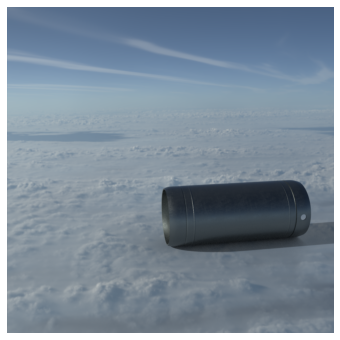

In [17]:
plt.figure(figsize=(9, 6))
plt.imshow(np.array(Image.open(train_dir_file_list[133]+file_img)))
plt.axis('off')

Looks good! We will look at the annotations later in this notebook.

# Analyze testing set

Now we will follow a similar procedure for analyzing the testing set.

In [18]:
# store json files
json_test_files = []
test_dir_list = []
for td in test_dir:
    for file in sorted(os.listdir(td)):
        if file.endswith('.json'):
            with open(td+file) as fn:
                s = fn.read()
                json_test_files.append(json.loads(s))  
                test_dir_list.append(td)

Find all the unique categories:

In [19]:
# skip over first category because labeled synthetic
test_categories = []
json_test_files_cats = []
test_dir_file_list = []
class_name_to_id_mapping = {}
for c, t in zip(json_test_files, test_dir_list):
    for idx, a in enumerate(c['annotations']):
#         if a['category'] != '30B':
#             continue
        json_test_files_cats.append(c)
        test_dir_file_list.append(t)
        test_categories.append(a['category'])
        break
test_categories = list(set(test_categories))
test_categories.sort()
print(test_categories)
# Dictionary that maps class names to IDs
for idx, cat in enumerate(test_categories):
    class_name_to_id_mapping[cat] = idx

['30B', '30Boverpack', '48G', '48X', '48Y', 'real']


# Look at one reference image

(-0.5, 799.5, 637.5, -0.5)

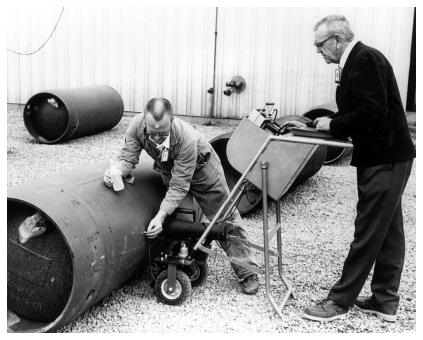

In [20]:
file_img = json_test_files_cats[0]['image']['filename']
plt.figure(figsize=(9, 6))
plt.imshow(np.array(Image.open(test_dir[0]+file_img)))
plt.axis('off')

# Create train/test dataset and convert to yolov5 format

Here we take our annotations and make them adhere to the yolo format. We use a function `convert_to_yolov5`. For tensorflow applications, there is a helper function that converts to `xml`.

We will aslo split our training set into a train and validation set. We will do 80% train, 10% validation, and 10% test. This will be used for training synthetic and testing synthetic. 

For training with synthetic but testing with real data, we will not split our data this way. We will use the train dataset but the validation dataset will be the reference dataset. We are treating validation as our testing set in this case based on the way yolov5 is setup.

In [21]:
train_dataset, val_dataset,\
train_dir_file_split, val_dir_file_split = train_test_split(json_files_cats,
                                                            train_dir_file_list,
                                                            test_size=0.2,
                                                            random_state=1)

val_dataset, syn_test_dataset, val_dir_file_split, syn_test_file_split = train_test_split(val_dataset,
                                                                                          val_dir_file_split,
                                                                                          test_size = 0.5,
                                                                                          random_state = 1)

* Train synthetic dataset

This will be used for train synthetic, test synthetic

In [22]:
# create new directory paths
# these directory paths build from the pwd
image_directory = 'example_train/images/'
label_directory = 'example_train/labels/'
dataset_train = 'train'

This creates the training set:

In [23]:
convert_to_yolov5(train_dataset,
                  categories_new,
                  dataset_train,
                  train_dir_file_split,
                  image_directory,
                  label_directory,
                  categories_new)

100%|██████████| 8000/8000 [23:51<00:00,  5.59it/s]


* Validation dataset

This will be used for train synthetic, test synthetic

In [24]:
# create new directory paths
# these directory paths build from the pwd
val_image_directory = 'example_val/images/'
val_label_directory = 'example_val/labels/'
dataset_val = 'val'

In [25]:
convert_to_yolov5(val_dataset,
                  categories_new,
                  dataset_val,
                  val_dir_file_split,
                  val_image_directory,
                  val_label_directory,
                  categories_new)

100%|██████████| 1000/1000 [02:55<00:00,  5.69it/s]


* Test dataset

This will be used for train synthetic, test synthetic

In [26]:
# create new directory paths
# these directory paths build from the pwd
test_image_directory = 'example_test/images/'
test_label_directory = 'example_test/labels/'
dataset_test = 'test'

In [27]:
convert_to_yolov5(syn_test_dataset,
                  categories_new,
                  dataset_test,
                  syn_test_file_split,
                  test_image_directory,
                  test_label_directory,
                  categories_new)

100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


# Confirm Bounding boxes

Now confirm the annotations before we train. We want to make sure that we correctly converted to the yolo format without ruining the location of the annotation.

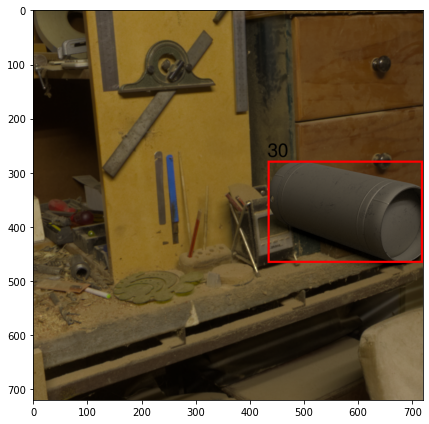

In [61]:
# Get any random annotation file
directory_test = f"{label_directory+dataset_train+'/'}"
directory_image = f"{image_directory+dataset_train+'/'}"
annotations = os.listdir(directory_test)
random_int = np.random.randint(len(annotations))
annotation_file = np.array(annotations)[random_int]
with open(directory_test + annotation_file, "r") as file:
    try:
        annotation_list = file.read().split("\n")[:-1]
        annotation_list = [x.split(" ") for x in annotation_list]
        annotation_list = [[float(y) for y in x ] for x in annotation_list]
    except ValueError:
        annotation_list = []

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(directory_image + image_file)

#Plot the Bounding Box
plot_bounding_box(directory_image + image_file,
                  categories_new,
                  annotation_list)

The annotation is correct! 

# Create train synthetic, test real data set

We will use the earlier converted training set data

# Convert Test Set

* labeling as validation but this will also serve as our testing set for the train synthetic, test real case

In [29]:
# train set will be json files
test_dataset = json_test_files_cats
# create new directory paths
# these directory paths build from the pwd
image_test_directory = 'example_train_synthetic_real_case/images/'
label_test_directory = 'example_train_synthetic_real_case/labels/'
dataset_test = 'val'

In [30]:
# This creates the training set
convert_to_yolov5(test_dataset,
                  test_categories,
                  dataset_test,
                  test_dir_file_list,
                  image_test_directory,
                  label_test_directory,
                  category_dict,
                  reference_imgs=True)

100%|██████████| 482/482 [00:39<00:00, 12.25it/s]


This command is necessary for some of the reference data:

In [31]:
correct_images(image_test_directory, dataset_test)

# Confirm bounding boxes

Confirm the annotations for the reference set!

62.txt 96


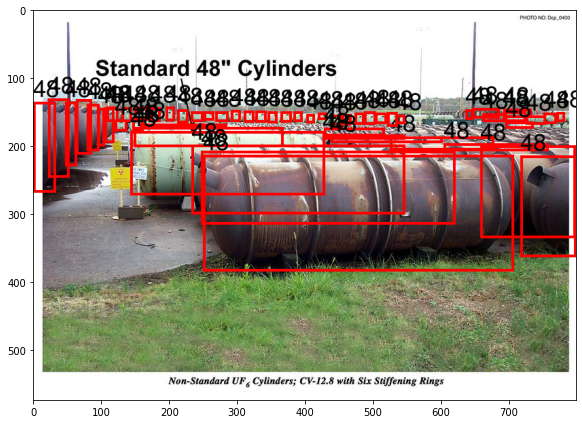

In [32]:
# Get any random annotation file
directory_test = f"{label_test_directory+dataset_test+'/'}"
directory_image = f"{image_test_directory+dataset_test+'/'}"
annotations = sorted(os.listdir(directory_test))
random_int = np.random.randint(len(annotations))
annotation_file = np.array(annotations)[random_int]
print(annotation_file, random_int)
with open(directory_test + annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]
#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "png")
assert os.path.exists(directory_image + image_file)

#Plot the Bounding Box
plot_bounding_box(directory_image + image_file,
                  category_dict,
                  annotation_list)

Looks good! 

# Create a yaml file

The yaml file is a mapping to your train and testing set. 

This cell will serve as the train synthetic, test synthetic yaml.

In [33]:
# train and val paths should be absolute
# also path of yaml file should live in yolov5/data
data = {'train':'/home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train/images/train/',
        'val':'/home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_val/images/val/',
        'test':'/home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/',
         'nc':len(categories_new),
         'names': categories_new
         }

with open('/home/mrmarsh/repos/yolov5/data/hybrid_imagery_example.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False,
              sort_keys=False)

* This cell will serve as the train synthetic, test real yaml.

In [34]:
# train and val paths should be absolute
# also path of yaml file should live in yolov5/data
data = {'train':'/home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train/images/train/',
        'val':'/home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/',
         'nc':len(categories_new),
         'names': categories_new
         }

with open('/home/mrmarsh/repos/yolov5/data/hybrid_imagery_example_train_syn_test_real.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False,
              sort_keys=False)

# Train the network

We have made it to the training section! The following code will train and validate the model for 400 epochs using synthetic data. Then it is evaluated using synthetic or real data.

The following command runs in bash. Tune parameters as needed. The below parameters are only for an example and should not be used when actually training:

In [40]:
!python /home/mrmarsh/repos/yolov5/train.py --img 640 --batch 32 --epochs 400 \
  --data  /home/mrmarsh/repos/yolov5/data/hybrid_imagery_example.yaml \
  --cfg  /home/mrmarsh/repos/yolov5/models/yolov5s.yaml\
  --weights /home/mrmarsh/repos/yolov5/models/yolov5s.pt \
  --name hybrid_imagery_example \
  --workers 128 \
  --save-period 10 \
  --cache \
  --patience 500

wandb: Currently logged in as: mrmarsh. Use `wandb login --relogin` to force relogin
train: weights=/home/mrmarsh/repos/yolov5/models/yolov5s.pt, cfg=/home/mrmarsh/repos/yolov5/models/yolov5s.yaml, data=/home/mrmarsh/repos/yolov5/data/hybrid_imagery_example.yaml, hyp=../../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=400, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=128, project=../../yolov5/runs/train, name=hybrid_imagery_example, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=500, freeze=[0], save_period=10, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v6.1-177-gd059d1d torch 1.11.0 CUDA:0 (Quadro RTX 6000, 24198MiB

     0/399     6.98G    0.1156   0.02549   0.04791        27       640:   1%|   Exception in thread Thread-38:
Traceback (most recent call last):
  File "/home/mrmarsh/repos/yolov5/utils/plots.py", line 57, in check_pil_font
    return ImageFont.truetype(str(font) if font.exists() else font.name, size)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 844, in truetype
    return freetype(font)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 841, in freetype
    return FreeTypeFont(font, size, index, encoding, layout_engine)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 193, in __init__
    self.font = core.getfont(
OSError: unknown file format

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/threading.py", line 973, in _

    12/399     8.78G    0.0181  0.003967  0.005199        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.936      0.947      0.981      0.884

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    13/399     8.78G   0.01823  0.003929  0.005318        15       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.963      0.916      0.974      0.861

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    14/399     8.78G   0.01752  0.003952  0.005218        24       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.957      0.909      0.964      0.868

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    15/399     8.78G   0.01708  0.003

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.977      0.952      0.987      0.941

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    38/399     8.78G   0.01422   0.00321  0.004248        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.975      0.978      0.991      0.941

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    39/399     8.78G   0.01382  0.003105  0.003427        28       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.986       0.96      0.989      0.954
Saving model artifact on epoch 40

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    40/399     8.78G   0.01364  0.003135  0.003628        17       640: 100%|███
   

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.988      0.983      0.994      0.973

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    63/399     8.78G    0.0124  0.002781  0.002586        18       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.991      0.977      0.994      0.976

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    64/399     8.78G   0.01209  0.002794  0.002882        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.991      0.978      0.994      0.977

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    65/399     8.78G   0.01241   0.00286  0.002935        18       640: 100%|███
               Class     Images     L


     Epoch   gpu_mem       box       obj       cls    labels  img_size
    88/399     8.78G   0.01183  0.002669  0.002601        18       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.993      0.974      0.994      0.981

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    89/399     8.78G   0.01159  0.002708  0.002537        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.986      0.989      0.994      0.983
Saving model artifact on epoch 90

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    90/399     8.78G    0.0116  0.002684  0.002358        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.993      0.979      0.994      0.983

  

   113/399     8.78G   0.01116  0.002679   0.00222        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.987      0.995      0.985

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   114/399     8.78G   0.01109  0.002618  0.002479        15       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.987      0.995      0.985

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   115/399     8.78G    0.0106  0.002601  0.002138        11       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.987      0.995      0.985

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   116/399     8.78G   0.01126  0.002

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.996      0.984      0.995      0.986

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   139/399     8.78G   0.01083  0.002443  0.002035        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.996      0.984      0.995      0.986
Saving model artifact on epoch 140

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   140/399     8.78G   0.01062  0.002469  0.002137        16       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.996      0.985      0.995      0.986

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   141/399     8.78G   0.01037  0.002472  0.001742        21       640: 100%|███
  

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.998      0.986      0.995      0.986

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   164/399     8.78G  0.009914  0.002383  0.002057        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.998      0.986      0.995      0.987

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   165/399     8.78G   0.01032  0.002353  0.001813        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.998      0.986      0.995      0.986

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   166/399     8.78G  0.009724  0.002316  0.001739        21       640: 100%|███
               Class     Images     L


     Epoch   gpu_mem       box       obj       cls    labels  img_size
   189/399     8.78G  0.009583  0.002295  0.001756        16       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.996      0.984      0.995      0.987
Saving model artifact on epoch 190

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   190/399     8.78G  0.009561  0.002294   0.00158        20       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.996      0.985      0.995      0.987

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   191/399     8.78G  0.009537  0.002352  0.001817        11       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.991      0.987      0.995      0.987

 

   214/399     8.78G  0.009465  0.002178   0.00178        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.987      0.995      0.987

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   215/399     8.78G  0.009296  0.002271  0.001936        24       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.987      0.995      0.987

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   216/399     8.78G   0.00906  0.002157  0.001414        20       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.987      0.995      0.987

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   217/399     8.78G  0.008916  0.002

   239/399     8.78G  0.008669  0.002106  0.001376        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.988      0.995      0.988
Saving model artifact on epoch 240

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   240/399     8.78G  0.008485  0.002119  0.001613        26       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.988      0.995      0.988

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   241/399     8.78G  0.008555  0.002091  0.001401        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.988      0.995      0.988

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  

   264/399     8.78G  0.008671  0.002116  0.001618        16       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.987      0.995      0.988

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   265/399     8.78G  0.008182  0.002026  0.001381        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.987      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   266/399     8.78G  0.008124  0.002004  0.001196        20       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.994      0.987      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   267/399     8.78G  0.008179  0.002

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.991      0.989      0.995      0.989
Saving model artifact on epoch 290

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   290/399     8.78G  0.007876  0.001914  0.001104        22       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.991      0.989      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   291/399     8.78G  0.007687  0.001884 0.0009966        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.991      0.989      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   292/399     8.78G  0.007494  0.001852   0.00111        13       640: 100%|███
  

   314/399     8.78G  0.006919  0.001771 0.0007918        24       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.989      0.992      0.995      0.988

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   315/399     8.78G  0.007053  0.001752 0.0007955        16       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.989      0.992      0.995      0.988

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   316/399     8.78G  0.006984  0.001757  0.000815        14       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483       0.99      0.992      0.995      0.988

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   317/399     8.78G  0.007007  0.001

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483       0.99      0.992      0.995      0.989
Saving model artifact on epoch 340

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   340/399     8.78G  0.006563  0.001647 0.0007575        20       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483       0.99      0.992      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   341/399     8.78G  0.006685  0.001699 0.0008283        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483       0.99      0.992      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   342/399     8.78G  0.006442   0.00166  0.001119        15       640: 100%|███
  

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.993      0.989      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   365/399     8.78G  0.005902  0.001553 0.0006204        15       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.993      0.989      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   366/399     8.78G  0.005897  0.001526 0.0007189        23       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.993      0.989      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   367/399     8.78G  0.005801  0.001561  0.000736        17       640: 100%|███
               Class     Images     L

   389/399     8.78G  0.005148   0.00141 0.0005128        20       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.993      0.992      0.995      0.989
Saving model artifact on epoch 390

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   390/399     8.78G   0.00517  0.001397 0.0004808        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.993      0.992      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   391/399     8.78G  0.005011  0.001415 0.0003338        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        991        483      0.993      0.992      0.995      0.989

     Epoch   gpu_mem       box       obj       cls    labels  img_size
  

Exception in thread Thread-43:
Traceback (most recent call last):
  File "/home/mrmarsh/repos/yolov5/utils/plots.py", line 57, in check_pil_font
    return ImageFont.truetype(str(font) if font.exists() else font.name, size)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 844, in truetype
    return freetype(font)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 841, in freetype
    return FreeTypeFont(font, size, index, encoding, layout_engine)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 193, in __init__
    self.font = core.getfont(
OSError: unknown file format

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/li

Exception ignored in: <function StorageWeakRef.__del__ at 0x7f4bc0074430>
Traceback (most recent call last):
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 36, in __del__
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/storage.py", line 520, in _free_weak_ref
AttributeError: 'NoneType' object has no attribute '_free_weak_ref'
Exception ignored in: <function StorageWeakRef.__del__ at 0x7f4bc0074430>
Traceback (most recent call last):
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 36, in __del__
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/storage.py", line 520, in _free_weak_ref
AttributeError: 'NoneType' object has no attribute '_free_weak_ref'
Exception ignored in: <function StorageWeakRef.__del__ at 0x7f4bc0074430>
Traceback (most recent call last):
  File "/home/mrmarsh/anaco

In [44]:
!python /home/mrmarsh/repos/yolov5/train.py --img 640 --batch 32 --epochs 400 \
  --data  /home/mrmarsh/repos/yolov5/data/hybrid_imagery_example_train_syn_test_real.yaml \
  --cfg  /home/mrmarsh/repos/yolov5/models/yolov5s.yaml\
  --weights /home/mrmarsh/repos/yolov5/models/yolov5s.pt \
  --name hybrid_imagery_example_train_syn_test_real \
  --workers 128 \
  --save-period 10 \
  --cache \
  --patience 500

wandb: Currently logged in as: mrmarsh. Use `wandb login --relogin` to force relogin
train: weights=/home/mrmarsh/repos/yolov5/models/yolov5s.pt, cfg=/home/mrmarsh/repos/yolov5/models/yolov5s.yaml, data=/home/mrmarsh/repos/yolov5/data/hybrid_imagery_example_train_syn_test_real.yaml, hyp=../../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=400, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=128, project=../../yolov5/runs/train, name=hybrid_imagery_example_train_syn_test_real, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=500, freeze=[0], save_period=10, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v6.1-177-gd059d1d torch 

     0/399     6.98G    0.1156   0.02549   0.04791        27       640:   1%|   Exception in thread Thread-38:
Traceback (most recent call last):
  File "/home/mrmarsh/repos/yolov5/utils/plots.py", line 57, in check_pil_font
    return ImageFont.truetype(str(font) if font.exists() else font.name, size)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 844, in truetype
    return freetype(font)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 841, in freetype
    return FreeTypeFont(font, size, index, encoding, layout_engine)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 193, in __init__
    self.font = core.getfont(
OSError: unknown file format

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/threading.py", line 973, in _

    12/399      9.2G    0.0181  0.003967  0.005199        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2427       0.19     0.0964       0.11     0.0653

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    13/399      9.2G   0.01823  0.003929  0.005318        15       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2427       0.15     0.0713     0.0738     0.0436

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    14/399      9.2G   0.01752  0.003952  0.005218        24       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2158      0.199     0.0753     0.0958     0.0543

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    15/399      9.2G   0.01708  0.003

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2427      0.168     0.0971      0.101     0.0605

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    38/399      9.2G   0.01422   0.00321  0.004248        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2408      0.276      0.093      0.145      0.088

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    39/399      9.2G   0.01382  0.003105  0.003427        28       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2427      0.245      0.107      0.144     0.0874
Saving model artifact on epoch 40

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    40/399      9.2G   0.01364  0.003135  0.003628        17       640: 100%|███
   

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2424      0.274     0.0997      0.155      0.098

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    63/399      9.2G    0.0124  0.002781  0.002586        18       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2374      0.246      0.104      0.167      0.109

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    64/399      9.2G   0.01209  0.002794  0.002882        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2388      0.267      0.101      0.149     0.0939

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    65/399      9.2G   0.01241   0.00286  0.002935        18       640: 100%|███
               Class     Images     L


     Epoch   gpu_mem       box       obj       cls    labels  img_size
    88/399      9.2G   0.01183  0.002669  0.002601        18       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2424      0.245      0.109      0.168      0.109

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    89/399      9.2G   0.01159  0.002708  0.002537        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2384      0.246      0.112      0.167      0.108
Saving model artifact on epoch 90

     Epoch   gpu_mem       box       obj       cls    labels  img_size
    90/399      9.2G    0.0116  0.002684  0.002358        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2354      0.234      0.111      0.163      0.106

  

   113/399      9.2G   0.01116  0.002679   0.00222        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2308      0.323     0.0936      0.168      0.111

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   114/399      9.2G   0.01109  0.002618  0.002479        15       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2310      0.247      0.103       0.17      0.112

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   115/399      9.2G    0.0106  0.002601  0.002138        11       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2310      0.287     0.0978      0.169      0.113

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   116/399      9.2G   0.01126  0.002

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2306      0.256      0.107      0.177      0.118

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   139/399      9.2G   0.01083  0.002443  0.002035        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2306      0.253      0.107      0.176      0.118
Saving model artifact on epoch 140

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   140/399      9.2G   0.01062  0.002469  0.002137        16       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2306      0.253      0.107      0.176      0.117

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   141/399      9.2G   0.01037  0.002472  0.001742        21       640: 100%|███
  

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2305       0.26      0.106      0.178       0.12

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   164/399      9.2G  0.009914  0.002383  0.002057        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2305       0.26      0.106      0.179       0.12

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   165/399      9.2G   0.01032  0.002353  0.001813        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2305       0.26      0.106      0.179      0.121

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   166/399      9.2G  0.009724  0.002316  0.001739        21       640: 100%|███
               Class     Images     L


     Epoch   gpu_mem       box       obj       cls    labels  img_size
   189/399      9.2G  0.009583  0.002295  0.001756        16       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2378      0.262      0.106      0.181      0.122
Saving model artifact on epoch 190

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   190/399      9.2G  0.009561  0.002294   0.00158        20       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2378      0.262      0.106       0.18      0.122

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   191/399      9.2G  0.009537  0.002352  0.001817        11       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2378      0.262      0.106       0.18      0.121

 

   214/399      9.2G  0.009465  0.002178   0.00178        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2344      0.267      0.103      0.184      0.124

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   215/399      9.2G  0.009296  0.002271  0.001936        24       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2344      0.267      0.103      0.184      0.124

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   216/399      9.2G   0.00906  0.002157  0.001414        20       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2344      0.267      0.103      0.184      0.124

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   217/399      9.2G  0.008916  0.002

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2343      0.326     0.0926      0.185      0.127
Saving model artifact on epoch 240

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   240/399      9.2G  0.008485  0.002119  0.001613        26       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2343      0.273     0.0984      0.185      0.127

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   241/399      9.2G  0.008555  0.002091  0.001401        21       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2343      0.327     0.0923      0.186      0.128

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   242/399      9.2G  0.008459  0.002025  0.001101        23       640: 100%|███
  

               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2342        0.3     0.0956      0.199      0.137

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   265/399      9.2G  0.008182  0.002026  0.001381        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2342      0.303     0.0956        0.2      0.137

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   266/399      9.2G  0.008124  0.002004  0.001196        20       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2342      0.302     0.0953        0.2      0.138

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   267/399      9.2G  0.008179  0.002046  0.001321        21       640: 100%|███
               Class     Images     L

Saving model artifact on epoch 290

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   290/399      9.2G  0.007876  0.001914  0.001104        22       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2335      0.324      0.091      0.211      0.146

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   291/399      9.2G  0.007687  0.001884 0.0009966        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2334      0.327      0.092      0.213      0.147

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   292/399      9.2G  0.007494  0.001852   0.00111        13       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2334      0.331     0.0929      0.215      0.148

 


     Epoch   gpu_mem       box       obj       cls    labels  img_size
   315/399      9.2G  0.007053  0.001752 0.0007955        16       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2316      0.339       0.09      0.218      0.154

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   316/399      9.2G  0.006984  0.001757  0.000815        14       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2316       0.34     0.0903      0.219      0.154

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   317/399      9.2G  0.007007  0.001754 0.0008991        23       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2316      0.339     0.0894      0.218      0.154

     Epoch   gpu_mem       box      

   340/399      9.2G  0.006563  0.001647 0.0007575        20       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2305      0.439     0.0831      0.231      0.161

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   341/399      9.2G  0.006685  0.001699 0.0008283        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2305      0.438     0.0832      0.231      0.161

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   342/399      9.2G  0.006442   0.00166  0.001119        15       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2305      0.442     0.0832      0.232      0.162

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   343/399      9.2G  0.006574  0.001

   365/399      9.2G  0.005902  0.001553 0.0006204        15       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2299      0.392     0.0854      0.243       0.17

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   366/399      9.2G  0.005897  0.001526 0.0007189        23       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2299      0.395     0.0854      0.244      0.171

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   367/399      9.2G  0.005801  0.001561  0.000736        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2299      0.395     0.0854      0.244      0.171

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   368/399      9.2G  0.005818  0.001

   390/399      9.2G   0.00517  0.001397 0.0004808        17       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2258      0.421     0.0859      0.257      0.181

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   391/399      9.2G  0.005011  0.001415 0.0003338        19       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2258      0.423     0.0859      0.258      0.182

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   392/399      9.2G   0.00513  0.001375 0.0004617        24       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5mAP@.
                 all        137       2258      0.425     0.0859      0.259      0.182

     Epoch   gpu_mem       box       obj       cls    labels  img_size
   393/399      9.2G  0.005021  0.001

OSError: unknown file format
    return freetype(font)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 841, in freetype
    self._target(*self._args, **self._kwargs)
  File "/home/mrmarsh/repos/yolov5/utils/plots.py", line 217, in plot_images
    return FreeTypeFont(font, size, index, encoding, layout_engine)
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/PIL/ImageFont.py", line 193, in __init__
    annotator = Annotator(mosaic, line_width=round(fs / 10), font_size=fs, pil=True, example=names)
  File "/home/mrmarsh/repos/yolov5/utils/plots.py", line 77, in __init__
    self.font = core.getfont(
OSError: unknown file format

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.font = check_pil_font(font='Arial.Unicode.ttf' if non_ascii else font,

Exception ignored in: <function StorageWeakRef.__del__ at 0x7f76f5578430>
Traceback (most recent call last):
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 36, in __del__
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/storage.py", line 520, in _free_weak_ref
AttributeError: 'NoneType' object has no attribute '_free_weak_ref'
Exception ignored in: <function StorageWeakRef.__del__ at 0x7f76f5578430>
Traceback (most recent call last):
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/multiprocessing/reductions.py", line 36, in __del__
  File "/home/mrmarsh/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/storage.py", line 520, in _free_weak_ref
AttributeError: 'NoneType' object has no attribute '_free_weak_ref'
Exception ignored in: <function StorageWeakRef.__del__ at 0x7f76f5578430>
Traceback (most recent call last):
  File "/home/mrmarsh/anaco

# Detect

Let's run inference and visualize how well the model does. We are using a 25% confidence. This is more applicable for the train synthetic, test real case.

In [45]:
!python /home/mrmarsh/repos/yolov5/detect.py \
--source /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/ \
--weights /home/mrmarsh/repos/yolov5/runs/train/hybrid_imagery_example/weights/best.pt \
--conf 0.25 \
--name hybrid_imagery_example_inference

detect: weights=['/home/mrmarsh/repos/yolov5/runs/train/hybrid_imagery_example/weights/best.pt'], source=/home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/, data=../../yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../../yolov5/runs/detect, name=hybrid_imagery_example_inference, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-177-gd059d1d torch 1.11.0 CUDA:0 (Quadro RTX 6000, 24198MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/0.png: 640x640 1 30, Done. (0.009s)
image 2/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_

image 56/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/148.png: 640x640 1 48, Done. (0.010s)
image 57/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/149.png: 640x640 Done. (0.007s)
image 58/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/15.png: 640x640 1 30, Done. (0.007s)
image 59/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/150.png: 640x640 Done. (0.007s)
image 60/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/151.png: 640x640 1 48, Done. (0.007s)
image 61/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/152.png: 640x640 Done. (0.007s)
image 62/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/153.png: 640x640 1 48, Done. (0.007s)
image 63/998 /home/mrmarsh/repos/hybrid_imager

image 116/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/201.png: 640x640 1 48, Done. (0.007s)
image 117/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/202.png: 640x640 1 48, Done. (0.010s)
image 118/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/203.png: 640x640 1 30, Done. (0.007s)
image 119/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/204.png: 640x640 1 48, Done. (0.006s)
image 120/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/205.png: 640x640 Done. (0.010s)
image 121/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/206.png: 640x640 1 30, Done. (0.011s)
image 122/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/207.png: 640x640 Done. (0.010s)
image 123/998 /home/mrmarsh/repo

image 176/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/256.png: 640x640 Done. (0.010s)
image 177/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/257.png: 640x640 1 48, Done. (0.007s)
image 178/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/258.png: 640x640 1 48, Done. (0.007s)
image 179/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/259.png: 640x640 Done. (0.007s)
image 180/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/26.png: 640x640 Done. (0.007s)
image 181/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/260.png: 640x640 Done. (0.007s)
image 182/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/261.png: 640x640 1 30, Done. (0.010s)
image 183/998 /home/mrmarsh/repos/hybrid_imag

image 236/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/31.png: 640x640 Done. (0.009s)
image 237/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/310.png: 640x640 Done. (0.007s)
image 238/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/311.png: 640x640 1 48, Done. (0.007s)
image 239/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/312.png: 640x640 1 48, Done. (0.007s)
image 240/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/313.png: 640x640 1 48, Done. (0.009s)
image 241/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/314.png: 640x640 Done. (0.009s)
image 242/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/315.png: 640x640 Done. (0.010s)
image 243/998 /home/mrmarsh/repos/hybrid_imag

image 296/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/364.png: 640x640 1 48, Done. (0.008s)
image 297/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/365.png: 640x640 1 30, Done. (0.009s)
image 298/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/366.png: 640x640 1 48, Done. (0.007s)
image 299/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/367.png: 640x640 Done. (0.008s)
image 300/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/368.png: 640x640 1 48, Done. (0.007s)
image 301/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/369.png: 640x640 Done. (0.008s)
image 302/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/37.png: 640x640 1 30, Done. (0.007s)
image 303/998 /home/mrmarsh/repos

image 356/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/418.png: 640x640 1 48, Done. (0.011s)
image 357/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/419.png: 640x640 1 48, Done. (0.008s)
image 358/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/42.png: 640x640 Done. (0.009s)
image 359/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/420.png: 640x640 1 30, Done. (0.007s)
image 360/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/421.png: 640x640 Done. (0.007s)
image 361/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/422.png: 640x640 Done. (0.007s)
image 362/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/423.png: 640x640 1 48, Done. (0.007s)
image 363/998 /home/mrmarsh/repos/hybri

image 417/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/473.png: 640x640 Done. (0.010s)
image 418/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/474.png: 640x640 1 30, Done. (0.007s)
image 419/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/475.png: 640x640 Done. (0.007s)
image 420/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/476.png: 640x640 1 30, Done. (0.007s)
image 421/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/477.png: 640x640 1 48, Done. (0.007s)
image 422/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/478.png: 640x640 1 48, Done. (0.007s)
image 423/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/479.png: 640x640 Done. (0.010s)
image 424/998 /home/mrmarsh/repos/hybr

image 477/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/527.png: 640x640 1 30, Done. (0.009s)
image 478/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/528.png: 640x640 1 48, Done. (0.007s)
image 479/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/529.png: 640x640 1 48, Done. (0.007s)
image 480/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/53.png: 640x640 1 48, Done. (0.010s)
image 481/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/530.png: 640x640 Done. (0.007s)
image 482/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/531.png: 640x640 Done. (0.007s)
image 483/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/532.png: 640x640 Done. (0.007s)
image 484/998 /home/mrmarsh/repos/hybri

image 538/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/582.png: 640x640 1 48, Done. (0.007s)
image 539/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/583.png: 640x640 Done. (0.012s)
image 540/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/584.png: 640x640 1 30, Done. (0.009s)
image 541/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/585.png: 640x640 Done. (0.010s)
image 542/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/586.png: 640x640 Done. (0.007s)
image 543/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/587.png: 640x640 1 30, Done. (0.009s)
image 544/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/588.png: 640x640 1 30, Done. (0.007s)
image 545/998 /home/mrmarsh/repos/hybr

image 598/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/636.png: 640x640 1 48, Done. (0.009s)
image 599/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/637.png: 640x640 Done. (0.007s)
image 600/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/638.png: 640x640 Done. (0.008s)
image 601/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/639.png: 640x640 Done. (0.007s)
image 602/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/64.png: 640x640 1 30, Done. (0.007s)
image 603/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/640.png: 640x640 Done. (0.012s)
image 604/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/641.png: 640x640 Done. (0.007s)
image 605/998 /home/mrmarsh/repos/hybrid_imagery/ex

image 659/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/691.png: 640x640 Done. (0.007s)
image 660/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/692.png: 640x640 Done. (0.009s)
image 661/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/693.png: 640x640 1 30, Done. (0.007s)
image 662/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/694.png: 640x640 1 48, Done. (0.007s)
image 663/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/695.png: 640x640 1 30, Done. (0.010s)
image 664/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/696.png: 640x640 1 48, Done. (0.007s)
image 665/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/697.png: 640x640 Done. (0.007s)
image 666/998 /home/mrmarsh/repos/hybr

image 719/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/745.png: 640x640 1 30, Done. (0.007s)
image 720/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/746.png: 640x640 1 48, Done. (0.007s)
image 721/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/747.png: 640x640 1 30, Done. (0.007s)
image 722/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/748.png: 640x640 1 30, Done. (0.009s)
image 723/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/749.png: 640x640 Done. (0.007s)
image 724/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/75.png: 640x640 1 48, Done. (0.010s)
image 725/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/750.png: 640x640 1 48, Done. (0.011s)
image 726/998 /home/mrmarsh

image 779/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/8.png: 640x640 Done. (0.008s)
image 780/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/80.png: 640x640 Done. (0.009s)
image 781/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/800.png: 640x640 Done. (0.016s)
image 782/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/801.png: 640x640 1 30, Done. (0.009s)
image 783/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/802.png: 640x640 1 30, Done. (0.009s)
image 784/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/803.png: 640x640 1 30, Done. (0.007s)
image 785/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/804.png: 640x640 1 30, Done. (0.007s)
image 786/998 /home/mrmarsh/repos/hybrid_

image 839/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/853.png: 640x640 1 48, Done. (0.007s)
image 840/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/854.png: 640x640 Done. (0.009s)
image 841/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/855.png: 640x640 1 30, Done. (0.007s)
image 842/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/856.png: 640x640 1 48, Done. (0.007s)
image 843/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/857.png: 640x640 1 48, Done. (0.007s)
image 844/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/858.png: 640x640 Done. (0.007s)
image 845/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/859.png: 640x640 Done. (0.007s)
image 846/998 /home/mrmarsh/repos/hybr

image 900/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/908.png: 640x640 1 30, Done. (0.011s)
image 901/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/909.png: 640x640 Done. (0.007s)
image 902/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/91.png: 640x640 1 30, Done. (0.007s)
image 903/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/910.png: 640x640 1 48, Done. (0.007s)
image 904/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/911.png: 640x640 1 30, Done. (0.007s)
image 905/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/912.png: 640x640 1 48, Done. (0.007s)
image 906/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/913.png: 640x640 1 48, Done. (0.009s)
image 907/998 /home/mrmarsh

image 960/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/962.png: 640x640 1 48, Done. (0.010s)
image 961/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/963.png: 640x640 1 48, Done. (0.007s)
image 962/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/964.png: 640x640 Done. (0.007s)
image 963/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/965.png: 640x640 1 48, Done. (0.007s)
image 964/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/966.png: 640x640 1 30, Done. (0.007s)
image 965/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/967.png: 640x640 1 48, Done. (0.007s)
image 966/998 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_test/images/test/968.png: 640x640 Done. (0.007s)
image 967/998 /home/mrmarsh/repo

View some detections:

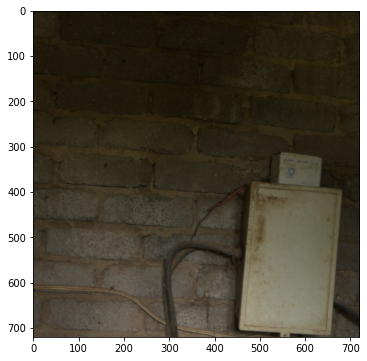

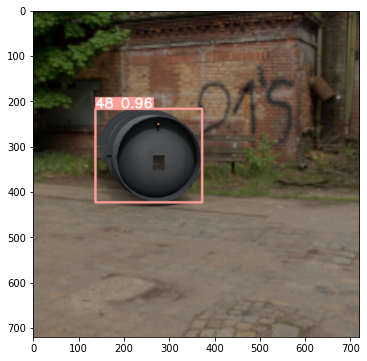

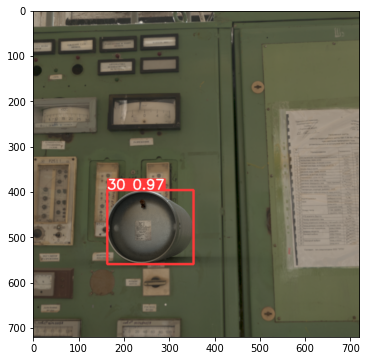

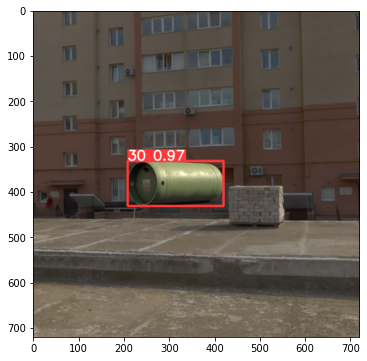

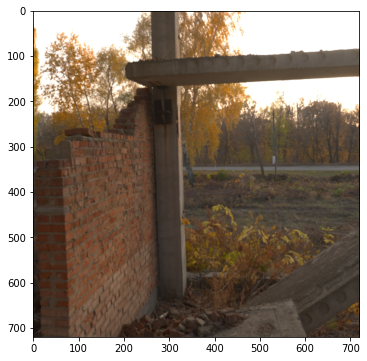

In [51]:
detections_dir = "/home/mrmarsh/repos/yolov5/runs/detect/hybrid_imagery_example_inference/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

for i in range(5):
    random_detection_image = Image.open(random.choice(detection_images))
    plt.figure(figsize=(9, 6))
    plt.imshow(np.array(random_detection_image))

Train synthetic, test synthetic is behaving the way we would expect. The training and testing set are drawn from the same distribution so inference should perform well.

In [47]:
!python /home/mrmarsh/repos/yolov5/detect.py \
--source /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/ \
--weights /home/mrmarsh/repos/yolov5/runs/train/hybrid_imagery_example/weights/best.pt \
--conf 0.25 \
--name hybrid_imagery_example_train_syn_test_real

detect: weights=['/home/mrmarsh/repos/yolov5/runs/train/hybrid_imagery_example/weights/best.pt'], source=/home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/, data=../../yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../../yolov5/runs/detect, name=hybrid_imagery_example_train_syn_test_real, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-177-gd059d1d torch 1.11.0 CUDA:0 (Quadro RTX 6000, 24198MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/0.png: 512x640 1 30, Done. (0.013s)
image 2/137 /ho

image 49/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/19.png: 448x640 Done. (0.007s)
image 50/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/2.png: 608x640 Done. (0.020s)
image 51/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/20.png: 512x640 Done. (0.007s)
image 52/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/21.png: 512x640 1 30, Done. (0.007s)
image 53/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/22.png: 512x640 Done. (0.006s)
image 54/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/23.png: 480x640 4 30s, Done. (0.007s)
image 55/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/

image 103/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/68.png: 448x640 Done. (0.007s)
image 104/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/69.png: 448x640 1 48, Done. (0.006s)
image 105/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/7.png: 480x640 Done. (0.007s)
image 106/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/70.png: 384x640 Done. (0.007s)
image 107/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/71.png: 480x640 Done. (0.006s)
image 108/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_limbo/example_train_synthetic_real_case/images/val/72.png: 416x640 1 48, Done. (0.013s)
image 109/137 /home/mrmarsh/repos/hybrid_imagery/example_notebooks_for_

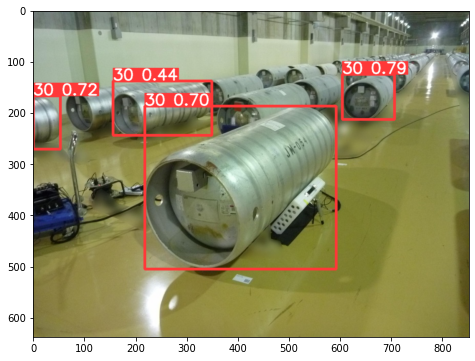

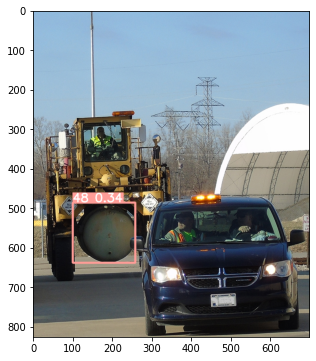

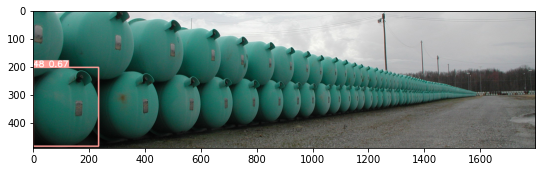

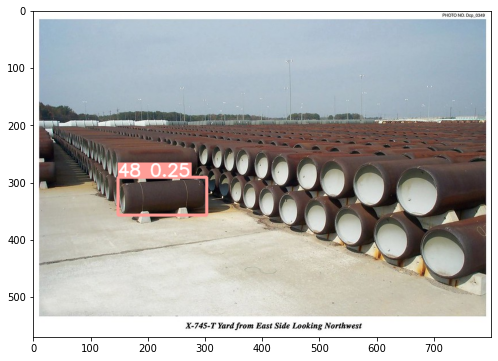

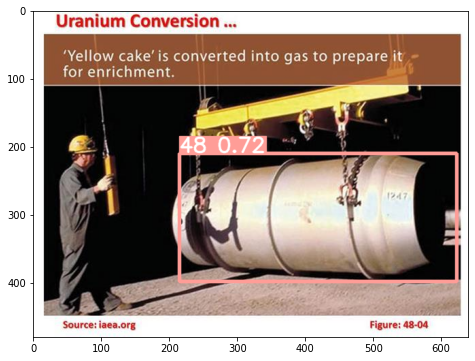

In [48]:
detections_dir = "/home/mrmarsh/repos/yolov5/runs/detect/hybrid_imagery_example_train_syn_test_real/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

for i in range(5):
    random_detection_image = Image.open(random.choice(detection_images))
    plt.figure(figsize=(9, 6))
    plt.imshow(np.array(random_detection_image))

Not bad given our training set. You will note that the object detector typically only detects one container of interest in a row of containers. By incorporating more campaigns into the training set we could improve performance. Also, in some cases, we do not even detect a contain of interest even though the container is quite obvious. This demonstrates some of the difficulty with training synthetic and testing real. There are differences in the feature spaces that are not readily apparent. 

# View Loss curves 

Looking at the train synthetic test synthetic data, we see some patterns:

* Training loss steadily decreases.
* Precision/Recall steadily increase until reaching about 1.0 around 50 epochs and hover there for the remainder of the training. 
* Overall, we can have confidence that the train synthetic, test synthetic use case is working the way we would expect.

* Note - plot_results is from yolov5 utils code

In [52]:
def plot_results(file='path/to/results.csv', dir=''):
    # Plot training results.csv. Usage: from utils.plots import *; plot_results('path/to/results.csv')
    save_dir = Path(file).parent if file else Path(dir)
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), tight_layout=True)
    ax = ax.ravel()
    files = list(save_dir.glob('results*.csv'))
    assert len(files), f'No results.csv files found in {save_dir.resolve()}, nothing to plot.'
    for fi, f in enumerate(files):
        try:
            data = pd.read_csv(f)
            s = [x.strip() for x in data.columns]
            x = data.values[:, 0]
            for i, j in enumerate([1, 2, 3, 4, 5, 8, 9, 10, 6, 7]):
                y = data.values[:, j].astype('float')
                # y[y == 0] = np.nan  # don't show zero values
                ax[i].plot(x, y, marker='.', label=f.stem, linewidth=2, markersize=8)
                ax[i].set_title(s[j], fontsize=12)
                # if j in [8, 9, 10]:  # share train and val loss y axes
                #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])
        except Exception as e:
            LOGGER.info(f'Warning: Plotting error for {f}: {e}')
    ax[1].legend()
    plt.show()
    fig.savefig(save_dir / 'results.png', dpi=200)
    plt.close()

In [53]:
dir_path = '/home/mrmarsh/repos/yolov5/runs/train/hybrid_imagery_example/weights/'
epoch_dir = os.listdir(dir_path)

In [54]:
results_path = '/home/mrmarsh/repos/yolov5/runs/train/hybrid_imagery_example/results.csv'

# Train synthetic, test synthetic

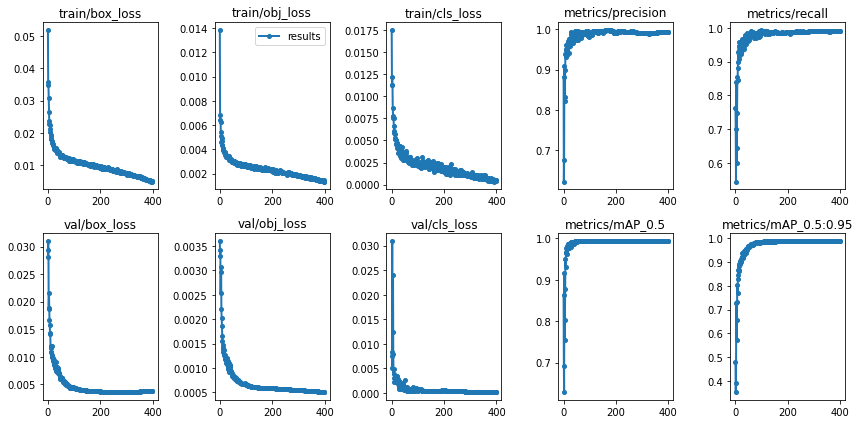

In [55]:
plot_results(results_path)

# Train synthetic, test real

* The loss function steadily increases (the opposite of what we would like) - this highlights the fact that the synthetic and real images are drawn from different distributions, even though the synthetic data is often mistaken for real data by humans.
* Training could be improved by incorporating more campaigns in the training set. As seen by inference, the model struggles to detect multiple containers in a row. By using Campaign4 and/or Campaign5 we could improve our metrics. Additionally, using Campaigns that contain distractors and occluding objects could improve precision and recall.
* mAP score is increasing at 400 epochs. We could have continued training for more epochs to increase that score; however, recall started decreasing around 200 epochs.

In [56]:
dir_path = '/home/mrmarsh/repos/yolov5/runs/train/hybrid_imagery_example_train_syn_test_real/weights/'
epoch_dir = os.listdir(dir_path)

In [57]:
results_path = '/home/mrmarsh/repos/yolov5/runs/train/hybrid_imagery_example_train_syn_test_real/results.csv'

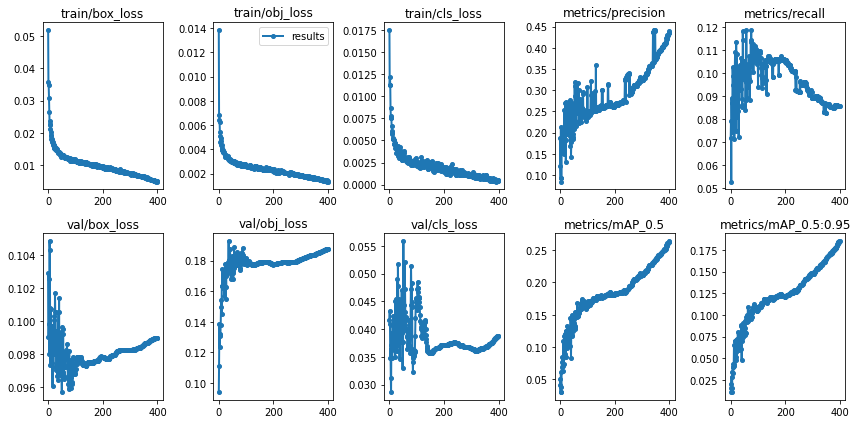

In [58]:
plot_results(results_path)